In [1]:
# setup env
try: # in collab
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  reporoot = "/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/Mylesgitrepo"
  datadir = "/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data"
  %cd $reporoot
  ! pip install -r requirements.txt
  ! pip install scipy==1.12.0 # this notebook requires this specific version, which is different from requirements.txt file
except: # not in collab
  reporoot = "/home/myles/uiuc/DLH/ecg-transfer-learning"
  datadir = "/home/myles/uiuc/DLH/ecg-transfer-learning/data"
  %cd $reporoot

/home/myles/uiuc/DLH/ecg-transfer-learning


In [2]:
from transplant.datasets.icentia11k import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import ShortTimeFFT

# valid patient ids in small unzipped dataset: [0, 1, 88, 89, 96, 97, 98, 99, 100, 109, 166, 167, 168, 186, 187, 188, 189, 190, 191, 196, 197, 221, 222, 223, 236]
patient_id = 1
data_idx = 1
db_dir = datadir + '/icentia11k_subset_unzipped'
print(db_dir)
# patient_data = load_patient_data(db_dir, patient_id, unzipped=False)

(ecg_signal, labels) = load_patient_data(db_dir, patient_id, include_labels=True, unzipped=True)

# lets explore the data a bit
print("Patient id: ", patient_id)
print("Number of ECG signals: ", len(ecg_signal))
print("Length of of ECG at index: ", len(ecg_signal[data_idx]))

2024-04-14 20:20:39.746204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset_unzipped
Patient id:  1
Number of ECG signals:  50
Length of of ECG at index:  1048577


twindow is 16.384 with N 4096 and fsample 250.0


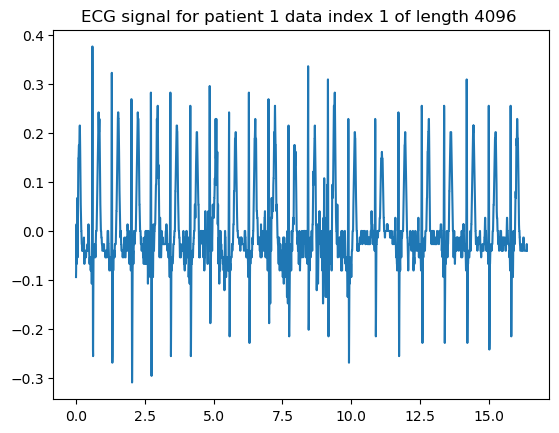

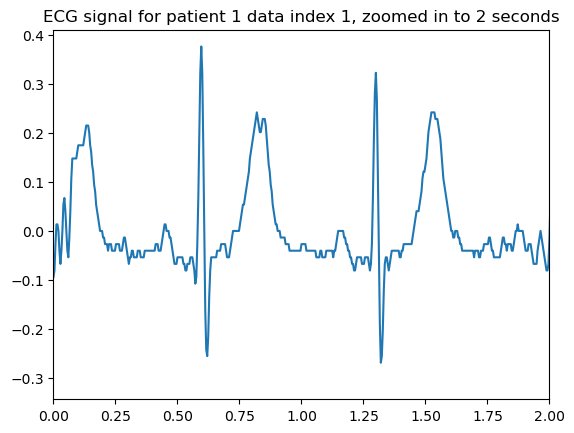

In [4]:
# lets select a portion of the signal and plot it in timedomain
data_idx = 1;
fsample = 250.0;
T_x = 1.0/fsample

# lets target a 64x64 spectogram. This is 64 time slices, and 64 frequency components
window_size = 256 # number of samples per time slice
stride=64
n_time_slices = 64
N = 4096 # total number of samples for full spectogram
twindow = N/fsample
print(f"twindow is {twindow} with N {N} and fsample {fsample}")

# grab the selected part of the signal (first N points)
selected_signal =ecg_signal[data_idx][:N];

# plot the selected signal in time domain
t_x = np.arange(N) * T_x


# lets plot signal
plt.plot(t_x, selected_signal)
# print title with info on length
title = f"ECG signal for patient {patient_id} data index {data_idx} of length {len(selected_signal)} "
plt.title(title)
plt.show()

# and now zoomed in
plt.plot(t_x, selected_signal)
plt.xlim([0, 2])
title = f"ECG signal for patient {patient_id} data index {data_idx}, zoomed in to 2 seconds"
plt.title(title)
plt.show()


(129, 67)


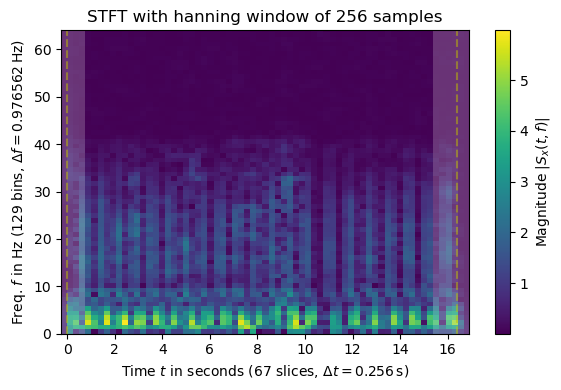

In [5]:
# lets compute an short time fft  (spectogram)

# Lets chose a hanning window
# this is like a 1D convolution, that helps smooth out the spectogram across time slices,
# and makes them periodic across the window to satisfy FFT assumptions
w = np.hanning(window_size)

# lets do the actual spectogram (series of fft frequency decompositions over time)
# print inputs:
SFT = ShortTimeFFT(w, hop=stride, fs=1/T_x);
Sx = SFT.stft(selected_signal)
print(Sx.shape)

# lets plot the spectogram
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT with hanning window of {window_size} samples")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
# we will not use these in our training
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
fig1.tight_layout()

# zoom into 0 to 40Hz on y axis (this seems to be where the action is)
ax1.set_ylim(0, 64)
plt.show()

True
False


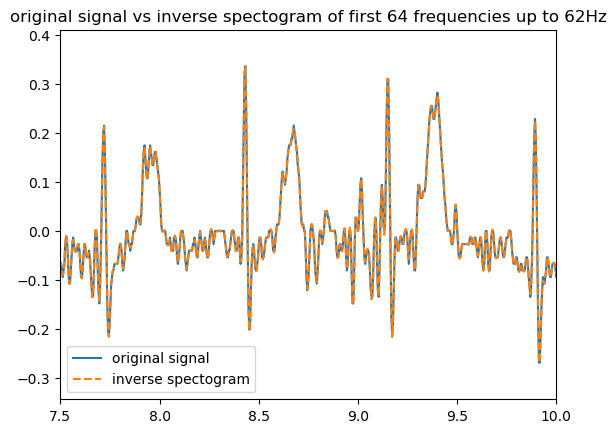

In [6]:
# Now lets see how good the spectogram captures the information in the time-domain signal
# we can do this by inverting the spectogram back to the time-domain signal
# Specifically, lets say we only want to keep lowest 64 frequencies ~(0-60Hz)
# we do this by setting elements 64:end,: to zero
output_size = 64
zero_indc  = output_size
Sx_compressed = Sx.copy()
Sx_compressed[(output_size +1):,:] = 0

# now lets calculate the inverse SFT
print(SFT.invertible)  # check if invertible
x1 = SFT.istft(Sx_compressed, k1=N)
print(np.allclose(selected_signal, x1))

plt.plot(t_x, selected_signal, t_x, x1, '--')
# print title with info on output size (how many frequencies we kept)
title = "original signal vs inverse spectogram of first {} frequencies up to {}Hz".format(output_size, int(SFT.delta_f*output_size))
plt.legend(["original signal", "inverse spectogram"])
plt.xlim([7.5, 10])
plt.title(title)
plt.show()


In [18]:

# lets define a 2d resnet
from transplant.modules.resnet2d import ResNet18_2D
import transplant.datasets.icentia11k as icentia11k
import tensorflow as tf

num_classes = len(icentia11k.ds_beat_names)
model = ResNet18_2D(num_classes=num_classes)
model.build(input_shape=(None, 64, 64, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')])
# model.compile(optimizer="adam",
#                 loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()


Model: "res_net18_2d_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          multiple                  3200      
                                                                 
 batch_normalization_40 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet_block_16 (ResnetBlo  multiple                  74368     
 ck)                                                             
                                                                 
 resnet_block_17 (ResnetBlo  multiple                  74368     
 ck)                                                

/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00000_batched.pkl.gz
(64, 64, 1)
tf.Tensor(1, shape=(), dtype=int32)


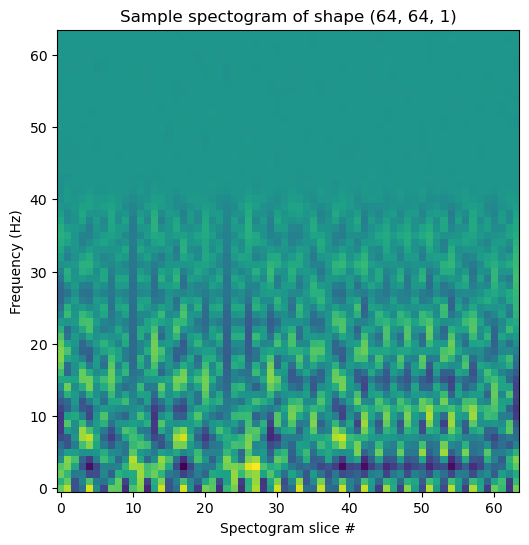

In [27]:
from transplant.datasets.icentia11k_spectogram import spectogram_beat_dataset

# lets test the generator
window_size = 256
stride = 64
n = 64
patient_ids = [100]
frame_size = 4096

db_dir = datadir + '/icentia11k_subset'
unzipped = False
patient_ids = np.array([0,1,88,89])#,96,97,98,99])

train_data = spectogram_beat_dataset(db_dir, patient_ids, frame_size,
                   unzipped=unzipped, samples_per_patient=128)

# Take 1 sample from the dataset
sample_output = train_data.take(1)

# Iterate over the sample_dataset to get the first element
for x, y in sample_output:
    # x and y are EagerTensor
    print(x.shape)
    print(y)

    # lets plot it
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(x[:,:,0], cmap='viridis')
    ax.set_title(f"Sample spectogram of shape {x.shape}")
    # add axis labels
    ax.set_xlabel("Spectogram slice #")
    ax.set_ylabel("Frequency (Hz)")
    ax.invert_yaxis()
    plt.show()
    break

In [ ]:
# ok lets try some training...
db_dir = datadir + '/icentia11k_subset'
unzipped = False
patient_ids = np.array([0,1,88,89])#,96,97,98,99])
train_data = spectogram_beat_dataset(db_dir, patient_ids, frame_size,
                   unzipped=unzipped, samples_per_patient=128)
batch_size = 32
train_data = train_data.batch(batch_size)

model.fit(train_data,
            steps_per_epoch = 16, # 3 batches per epoch
            verbose=2,
            epochs=2,
            validation_data=None,
            callbacks=[])

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00001_batched.pkl.gz
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00088_batched.pkl.gz
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00000_batched.pkl.gz
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00089_batched.pkl.gz
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00000_batched.pkl.gz
16/16 - 28s - loss: 1.2663 - acc: 0.7285 - 28s/epoch - 2s/step
Epoch 2/2
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00089_batched.pkl.gz
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_subset/00001_batched.pkl.gz
/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data/icentia11k_sub

/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  result = np.asarray(value, dtype=dtype, order="C")


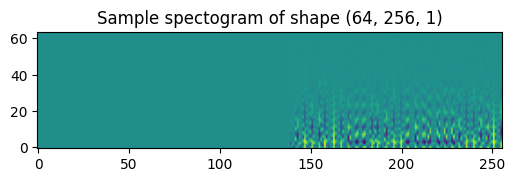

In [ ]:
from finetuning.utils import ecg_feature_extractor, train_test_split

def finetuning_spectogram_beat_generator(x_data, y_data, frame_size=2048, window_size=256, stride=64, n_freqs = 64, fs=250., shuffle = True):

    # initialize array of indices
    indices = np.arange(x_data.shape[0])
    while True:
        # data is a dictionary with data['x'] and data['y'] where data['x'] is a list of 1706 ECG signals of size (1706, 16384, 1)
        # lets loop through each of these getting x and y
        if shuffle:
            np.random.shuffle(indices)

        for i in indices: # loop through each sample
            x = x_data[i]  # Get the ith sample from data['x']
            y = y_data[i]  # Get the ith label from data['y']
            x = spectogram_preprocessor(
                x,
                frame_size=frame_size,
                window_size=window_size,
                stride=stride,
                n_freqs=n_freqs,
                fs=fs
                )

            yield x, y
# Now lets define the fine-tuning dataloaders
def _create_spectogram_dataset_from_data(data, frame_size=2048, window_size = 256, stride = 64,n_freqs = 64):
    output_size = frame_size//stride
    dataset = tf.data.Dataset.from_generator(
        generator=finetuning_spectogram_beat_generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=(tf.TensorShape((n_freqs, output_size, 1)), tf.TensorShape((4))),
        args=(data['x'], data['y'], frame_size, window_size, stride, n_freqs))
    return dataset


# inputs to data generators
val_size = 0.0625
batch_size = 32

# spectogram parameters
frame_size = 4096*4 # full size of input data

train_file = datadir + '/physionet_finetune/physionet_train.pkl'
test_file = datadir + '/physionet_finetune/physionet_test.pkl'

# load the data
train = load_pkl(train_file)
test = load_pkl(test_file)

# split into train and test
train, val = train_test_split(train, test_size=val_size, stratify=train['y'])

# create generators
train_data = _create_spectogram_dataset_from_data(train, frame_size=frame_size).batch(batch_size)
val_data = _create_spectogram_dataset_from_data(val, frame_size=frame_size).batch(batch_size) if val else None
test_data = _create_spectogram_dataset_from_data(test, frame_size=frame_size).batch(batch_size) if test else None
test_data = _create_spectogram_dataset_from_data(test, frame_size=frame_size)

sample_output = test_data.take(1)

# Iterate over the sample_dataset to get the first element
for x, y in sample_output:
    # x and y are EagerTensor

    # lets plot it
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(x[:,:,0], cmap='viridis')
    ax.set_title(f"Sample spectogram of shape {x.shape}")
    ax.invert_yaxis()
    plt.show()
    break



In [ ]:
from transplant.utils import (
    is_multiclass
)

# define model for finetuning
print(train['y'].shape)
num_classes = train['y'].shape[1]
finetuning_model = ResNet18(num_classes=num_classes)
if is_multiclass(train['y']):
    activation = 'sigmoid'
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy(name='acc')
else:
    activation = 'softmax'
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy(name='acc')
finetuning_model = tf.keras.Sequential([
        finetuning_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Flatten(),
        tf.keras.layers.Dense(num_classes, activation=activation)
    ])
finetuning_model.build(input_shape=(None, 64, 64*4, 1))
finetuning_model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss=loss,
                metrics=[accuracy])
# finetuning_model.compile(optimizer="adam",
#                 loss='categorical_crossentropy', metrics=["accuracy"])
finetuning_model.summary()





(6395, 4)


ValueError: Input 0 of layer "global_average_pooling2d_2" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 4)

In [ ]:
  batch_size = 32
train_data = train_data.batch(batch_size)

finetuning_model.fit(train_data,
            steps_per_epoch = 16, # 3 batches per epoch
            verbose=2,
            epochs=2,
            validation_data=None,
            callbacks=[])